In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'ryan'
category = 'natural'
eccentricity = 'periphery'
movie_id = 5
diameter = 6; # 6, 24, 36
dat_movie_name = 'PRAIRIE'   # movie name as in the data file name
stim_movie_name = 'prairie1' # movie name as in the stimulus file name

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prop_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
n_dim = n_frames - 1
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_frames-1, n_iter=50000, is_natural=True)

Optimization terminated successfully.
         Current function value: 0.068249
         Iterations: 2
         Function evaluations: 739


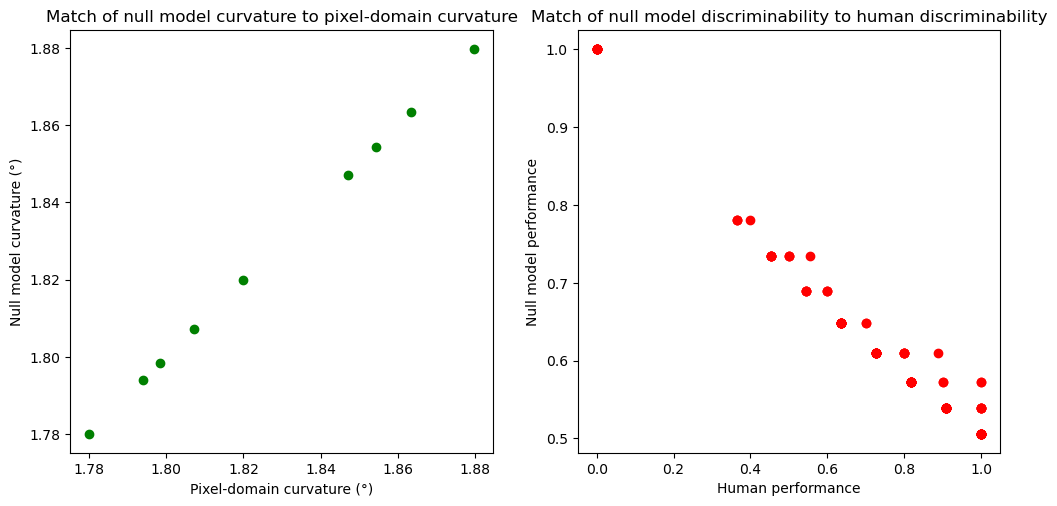

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
# axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Human performance')
axs[1].set_ylabel('Null model performance')
axs[1].set_box_aspect(1)

### Run optimization

In [6]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 594.8810383342206
Loss updated
Iteration 1 | Loss: 594.8810383342206
Current loss: 596.2243761569262
Iteration 2 | Loss: 596.2243761569262
Current loss: 570.5691629573703
Loss updated
Iteration 3 | Loss: 570.5691629573703
Iteration 4 | Loss: 581.3368267416954
Iteration 5 | Loss: 576.081356741488
Current loss: 577.8700268790126
Iteration 6 | Loss: 577.8700268790126
Current loss: 567.7337965071201
Loss updated
Iteration 7 | Loss: 567.7337965071201
Current loss: 592.2005618438125
Iteration 8 | Loss: 592.2005618438125
Current loss: 567.9836672693491
Iteration 9 | Loss: 567.9836672693491
Current loss: 559.1086231023073
Loss updated
Iteration 10 | Loss: 559.1086231023073
Epoch: 0, Loss: 1195.1407924824337
Epoch: 250, Loss: 1055.795574068534
Epoch: 500, Loss: 988.5528452920854
Epoch: 750, Loss: 928.9225450525771
Epoch: 1000, Loss: 887.4995784126287
Epoch: 1250, Loss: 857.9151414571213
Epoch: 1500, Loss: 832.2397238251

KeyboardInterrupt: 

### Analyze results

In [ ]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

NameError: name 'n_prop_corr' is not defined

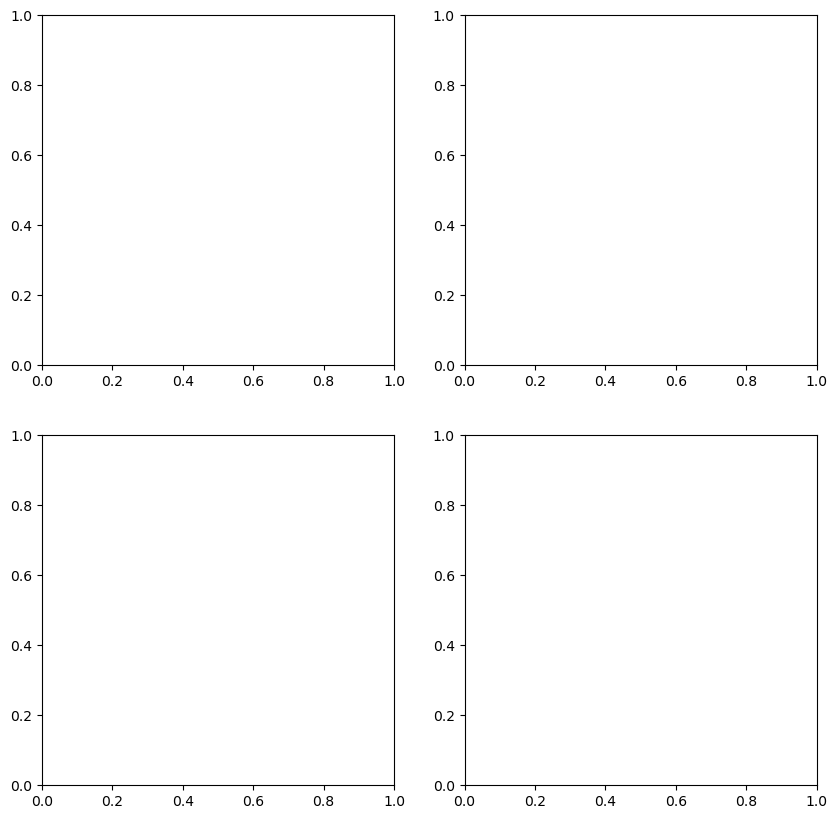

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prop_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prop_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()